## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pandas as pd

import time

import random

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

import manifolder as mr
from manifolder import helper as mh


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [4]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [5]:
import pickle
#Load Data
segments = np.load('themis\segments-newdata-all.npy')

# Load Labels
labels = np.load('themis\labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [6]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

reduce_dimension = False

for i in range(snippet_len,data_raw.shape[0]+1,snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,5]
        snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size

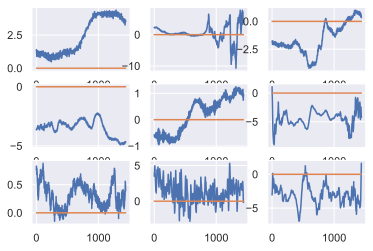

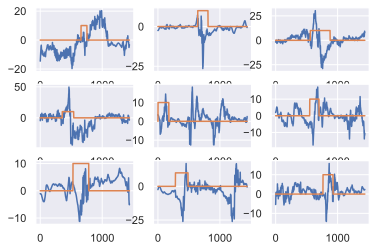

In [7]:
# import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()

In [10]:
# data has been parsed, now run Manifolder

dim=8
H = 160
step_size = 20
nbins = 10
ncov = 10

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs, parallel=True)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


Calculating histograms in parallel ... done in  6.04 seconds!
Computing local covariances in parallel ... done in  24.65 seconds!
using 4000 for variable m
computing Dis matrix in parallel
Python version is >= 3.8, using shared memory
done in  576.0 seconds!
aniostropic kernel ... Using partial symmetric eigensolver from scipy
done
extending embedding (building Psi) ... done

	 Program Executed in 612.96 seconds


In [11]:
#### snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_psi[i], snippet_psi[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)


	 Dcor Executed in 1.07 seconds
[[ 0.     11.5214 10.6551 ... 11.3915 11.3467 11.4289]
 [11.5214  0.      1.5119 ...  1.0323  0.1804  1.0313]
 [10.6551  1.5119  0.     ...  2.5151  1.8631  2.4342]
 ...
 [11.3915  1.0323  2.5151 ...  0.      0.876   0.367 ]
 [11.3467  0.1804  1.8631 ...  0.876   0.      0.9193]
 [11.4289  1.0313  2.4342 ...  0.367   0.9193  0.    ]]


In [12]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6656,)
(6656, 8)


Pickle file written successfully


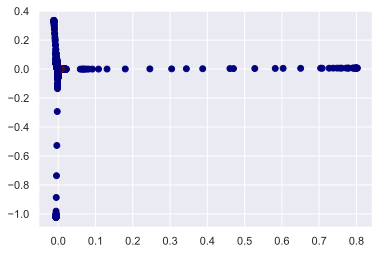

In [14]:
class EmptyObject:
    pass

results = EmptyObject()
#results.manifolder = manifolder
results.psi = manifolder.Psi
results.dcor_dm = dcor_dm
results.locallabel_downsample = locallabel_downsample
import pickle
try:
    pfile = open(".\clusteringResults.pickle", "wb+")
    pickle.dump(results, pfile)
    pfile.close()
    print("Pickle file written successfully")
except Exception as ex:
    print(ex)
    print("Unable to write pickle file")
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

In [15]:
print(results.dcor_dm.shape)

(104, 104)


In [11]:
from sklearn.cluster import KMeans
singledim = []
singleDimNumber = 0
for snippet in zs:
    singledim.append(snippet[:,singleDimNumber])

results = []
for i in range(1000):
    kmeans_orig = KMeans(n_clusters=2).fit(singledim)
    found = False
    for temp in results:
        if (kmeans_orig.labels_ == temp[0]).all() or (kmeans_orig.labels_ != temp[0]).all():
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeans_orig.labels_, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
cluster_out = results[-1][0]
print(cluster_out)
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative=0
for i in range(len(zs_0)):
    if cluster_out[i] == 0:
        trueNegative += 1
    else:
        falsePositive += 1
for i in range(len(zs_0), len(zs)):
    if cluster_out[i] == 1:
        truePositive += 1
    else:
        falseNegative += 1
print("TN:", trueNegative)
print("FP:", falsePositive)
print("TP:", truePositive)
print("FN:", falseNegative)

[[array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 1], [array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]), 2], [array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1

In [17]:
euclid_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = np.linalg.norm(zs[i] - zs[j])
        euclid_dm[i,j] = distance
        euclid_dm[j,i] = distance
print(euclid_dm)

[[     0.      98977.8804  45106.431  ... 153010.3569  90742.3736
  148929.0288]
 [ 98977.8804      0.     103168.5364 ... 178545.4886 127998.7653
  174135.9355]
 [ 45106.431  103168.5364      0.     ... 187467.4244 122027.9172
  183365.116 ]
 ...
 [153010.3569 178545.4886 187467.4244 ...      0.      77849.9263
    7911.2043]
 [ 90742.3736 127998.7653 122027.9172 ...  77849.9263      0.
   73607.7619]
 [148929.0288 174135.9355 183365.116  ...   7911.2043  73607.7619
       0.    ]]


In [28]:
#KMedoids clustering using Euclidean distance

from pyclustering.cluster.kmedoids import kmedoids

def try_medoids(nclust, dm):
    len_data = dm.shape[0]
    initial_medoids = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

results = []
for i in range(10000):
    kmeds = try_medoids(2, euclid_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
#print(results)
for a1 in results:
    print(a1)
    
for i in range(1):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative = 0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [60]], 2]
[[[62, 71], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]], 3]
[[[47, 77, 81], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3

In [29]:
#KMedoids clustering using manifolder+energy distance
from pyclustering.cluster.kmedoids import kmedoids

def try_medoids(nclust, dm):
    len_data = dm.shape[0]
    initial_medoids = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

results = []
for i in range(10000):
    kmeds = try_medoids(2, dcor_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) \
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(1):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 17, 18, 20, 25, 27, 37, 38, 39, 45, 51, 53, 55, 62, 64, 68, 80, 88, 95, 97, 99], [7, 9, 11, 13, 15, 19, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 54, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 96, 98, 100, 101, 102, 103]], 3263], [[[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 16, 17, 18, 20, 23, 25, 27, 37, 38, 39, 45, 48, 51, 53, 54, 55, 62, 64, 68, 70, 76, 80, 88, 90, 95, 97, 99, 102], [7, 9, 13, 15, 19, 21, 22, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 40, 41, 42, 43, 44, 46, 47, 49, 50, 52, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 69, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 96, 98, 100, 101, 103]], 6737]]
[[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 16, 17, 18, 20, 23, 25, 27, 37, 38, 39, 45, 48, 51, 53, 54, 55, 62, 64, 68, 70, 76, 80, 88, 90, 95, 97, 99, 1

In [30]:
#KMedoids clustering using dtw, summing each dimension
from pyclustering.cluster.kmedoids import kmedoids
import pickle

try:
    f = open("dtw_distmat_snippets_all_dims_sum.pickle", 'rb')
    dtw_distmat_all_dims_sum = pickle.load(f)
finally:
    f.close()

def try_medoids(nclust, dm):
    len_data = dm.shape[0]
    initial_medoids = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

results = []
for i in range(10000):
    kmeds = try_medoids(2, dtw_distmat_all_dims_sum)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(1):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[0, 1, 7, 8, 11, 13, 16, 17, 20, 23, 25, 28, 29, 30, 35, 41, 45, 50, 52, 53, 57, 58, 60, 64, 67, 69, 70, 73, 74, 76, 79, 85, 88, 89, 90, 92, 94, 95, 97, 101], [2, 3, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 21, 22, 24, 26, 27, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 51, 54, 55, 56, 59, 61, 62, 63, 65, 66, 68, 71, 72, 75, 77, 78, 80, 81, 82, 83, 84, 86, 87, 91, 93, 96, 98, 99, 100, 102, 103]], 2], [[[0, 1, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 56, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 71, 72, 74, 75, 77, 79, 80, 83, 84, 86, 87, 91, 95, 96, 98, 99, 100, 102], [2, 5, 6, 10, 19, 22, 24, 26, 31, 38, 42, 47, 50, 55, 57, 58, 63, 70, 73, 76, 78, 81, 82, 85, 88, 89, 90, 92, 93, 94, 97, 101, 103]], 2], [[[0, 3, 6, 8, 13, 16, 18, 20, 21, 23, 24, 26, 27, 29, 32, 37, 39, 40, 43, 44, 45, 50, 54, 56, 59, 61, 65, 67, 68, 69, 71, 72, 73, 75, 78, 82, 83, 84, 87, 89

In [31]:
#KMedoids clustering using manifolder+energy distance
from pyclustering.cluster.kmedoids import kmedoids
import pickle

try:
    f = open("dtw_distmat_snippets_all_dims.pickle", 'rb')
    dtw_distmat_all_dims = pickle.load(f)
finally:
    f.close()

def try_medoids(nclust, dm):
    len_data = dm.shape[0]
    initial_medoids = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

results = []
for i in range(10000):
    kmeds = try_medoids(2, dtw_distmat_all_dims)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(1):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[24, 43, 48, 54], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]], 1], [[[20], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]], 2], [[[67], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39

In [32]:
snippet_windows = []
#create windows for multivariate energy distance
for snip in range(len(zs)):
    z = zs[snip]
    num_dims = z.shape[1]
    i_range = int(np.floor(z.shape[0] - H) / step_size)
    window = np.zeros((H, i_range*num_dims))
    #print(window.shape)
    for dim in range(num_dims):
        for i in range(i_range):
            # interval = z(dim, 1 + (i - 1) * stepSize: (i - 1) * stepSize + H);
            interval = z[i * step_size:i * step_size + H, dim]
            #print(interval.shape)
            window[:,dim+i*num_dims] = interval[:]
    snippet_windows.append(window)

print(snippet_windows)


import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
#snippet_windows = manifolder.get_windows()
for i in range(len(snippet_windows)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_windows[i], snippet_windows[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)

[array([[  14.26,   -1.1 ,   49.15, ..., 2168.91, 2866.6 , 2634.04],
       [  14.28,   -1.04,   49.1 , ..., 2160.44, 2863.91, 2629.42],
       [  14.22,   -0.96,   49.03, ..., 2149.25, 2857.03, 2621.1 ],
       ...,
       [  13.88,   -0.72,   49.27, ..., 2269.91, 2868.58, 2669.03],
       [  13.78,   -0.72,   49.22, ..., 2281.99, 2867.46, 2672.31],
       [  13.71,   -0.77,   49.24, ..., 2288.8 , 2863.11, 2671.67]]), array([[ 13.61,   0.13,  32.03, ..., 211.05, 351.17, 304.47],
       [ 13.51,   0.19,  32.  , ..., 211.9 , 351.67, 305.08],
       [ 13.49,   0.16,  31.95, ..., 211.35, 350.72, 304.26],
       ...,
       [ 11.84,   0.57,  32.38, ..., 277.05, 369.78, 338.87],
       [ 11.82,   0.57,  32.34, ..., 285.74, 369.74, 341.74],
       [ 11.82,   0.53,  32.39, ..., 296.24, 369.72, 345.23]]), array([[  12.26,   -2.16,   51.54, ..., 2566.53, 3024.67, 2871.96],
       [  12.25,   -2.22,   51.53, ..., 2576.43, 3024.25, 2874.98],
       [  12.21,   -2.34,   51.48, ..., 2587.33, 3025.3


	 Dcor Executed in 269.6 seconds
[[      0.     2588727.3328  837001.463  ... 4902957.1544 2565936.9979
  4694508.9842]
 [2588727.3328       0.     2427324.4055 ... 5671512.2233 3663461.7298
  5452770.5294]
 [ 837001.463  2427324.4055       0.     ... 5804503.092  3364569.4685
  5592173.7012]
 ...
 [4902957.1544 5671512.2233 5804503.092  ...       0.     2181442.4701
   159914.0461]
 [2565936.9979 3663461.7298 3364569.4685 ... 2181442.4701       0.
  1965992.9425]
 [4694508.9842 5452770.5294 5592173.7012 ...  159914.0461 1965992.9425
        0.    ]]


In [33]:
#KMedoids clustering using energy distance
from pyclustering.cluster.kmedoids import kmedoids

def try_medoids(nclust, dm):
    len_data = dm.shape[0]
    initial_medoids = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

results = []
for i in range(10000):
    kmeds = try_medoids(2, dcor_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(1):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[7, 9, 11, 13, 15, 19, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 54, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 96, 98, 100, 101, 102, 103], [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 17, 18, 20, 25, 27, 37, 38, 39, 45, 51, 53, 55, 62, 64, 68, 80, 88, 95, 97, 99]], 3137], [[[7, 9, 13, 15, 19, 21, 22, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 40, 41, 42, 43, 44, 46, 47, 49, 50, 52, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 69, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 96, 98, 100, 101, 103], [0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 16, 17, 18, 20, 23, 25, 27, 37, 38, 39, 45, 48, 51, 53, 54, 55, 62, 64, 68, 70, 76, 80, 88, 90, 95, 97, 99, 102]], 6863]]
[[7, 9, 13, 15, 19, 21, 22, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 40, 41, 42, 43, 44, 46, 47, 49, 50, 52, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67,

In [34]:
#Cross-check of DTW versus Matlab
import math
x = []
for i in range(1000):
    x.append(math.cos(2*math.pi*((3*i/1000)**2)))
y = []
for i in range(400):
    y.append(math.cos(2*math.pi*18*i/400))

import dtw
temp = dtw.dtw(x,y)
print(temp.distance)

179.3527858690105
